### 설명
* 80/20 규칙은 많은 기업에 적용되며 소수의 고객만이 대부분의 수익을 창출한다. 따라서 마케팅 팀은 홍보 전략에 적절한 투자를 해야한다.
* 목표 : 고객 당 매출을 예측하기 위해 Google Merchandise Store고객데이터셋을 분석해야한다.
* 파일설명
    - train데이터 : 2016.08.01~2018.04.30
    - test데이터 : 2018.05.01~2018.10.15
    - 제출할 열은 2018.12.01~2019.01.31기간 동안에 대한 미래 예측

* Data Fields
    - fullVisitorId : Google Merchandise Store의 각 사용자에 대한 고유 식별자
    - channelGrouping : 사용자가 스토어를 방문한 채널
    - date : 사용자가 스토어를 방문한 날짜
    - device : 스토어에 접근하는데 사용된 장치의 사양
    - geoNetwork : 사용자의 지역에 대한 정보
    - socialEngagementType : 참여유형, Socially Engaged 또는 Not Socially Engaged
    - totals : 세션 전체의 총계 값
    - trafficSource : 세션이 시작된 트래픽 소스에 대한 정보
    - visitId : 세션의 식별자, 일반적으로 _utmb cookie로 저장되는 값의 일부이고 
    사용자에게만 고유한 것, 완전히 고유한 ID의 경우 fullVisitorId와 visitId조합 사용
    - visitNumber : 사용자의 세션 번호 (첫번째 세션인경우 1로 설정)
    - visitStartTime : 타임 스탬프 (POSIX 시간으로 표시)
    - hits : row and nested fields는 모든 종류의 hits에 대해 채워짐
    - customDimensions : 이 섹션에는 세션에 대해 설정된 모든 사용자 수준 또는 세션 수준 
    사용자 지정 차원이 포함, 이 필드는 반복되는 필드이며 설정된 각 차원에 대한 항목이 있음
    - totals : 이 열 세트에는 주로 고급 집계 데이터가 포함

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
%%time
train_df = load_df()
test_df = load_df("test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
Wall time: 4min 37s


In [4]:
train_df.to_csv('train_df.csv',index = False)
test_df.to_csv('test_df.csv',index = False)

In [5]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

11515 


In [6]:
train_df.fullVisitorId.nunique()

714167

- 고유 방문자는 714167명입니다

In [9]:
train_df.visitId.nunique()

886303

- 필드는 더이상 사용하지 않습니다. 
https://support.google.com/analytics/answer/3437719?hl=ko

In [8]:
train_df[train_df['totals.transactionRevenue'].notnull()].fullVisitorId.nunique()

9996

- 결제한 고유 고객은 9996명입니다.

In [16]:
new_train_df = train_df[train_df['totals.transactionRevenue'].notnull()]

In [17]:
new_train_df

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
752,Direct,20160902,6194193421514403509,6194193421514403509_1472843572,Not Socially Engaged,1472843572,1,1472843572,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,11,11,NaN,1,37860000,(not set),(direct),(none),NaN,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Organic Search,20160902,5327166854580374902,5327166854580374902_1472844906,Not Socially Engaged,1472844906,3,1472844906,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,11,10,NaN,NaN,306670000,(not set),google,organic,(not provided),not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,Referral,20160902,8885051388942907862,8885051388942907862_1472827393,Not Socially Engaged,1472827393,7,1472827393,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,13,11,NaN,NaN,68030000,(not set),mall.googleplex.com,referral,NaN,not available in demo dataset,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Referral,20160902,0185467632009737931,0185467632009737931_1472846398,Not Socially Engaged,1472846398,6,1472846398,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,no

In [9]:
device = train_df.iloc[:, 9:24]

In [10]:
geoNetwork=train_df.iloc[:, 24:35]

In [11]:
totals = train_df.iloc[:, 35:41]

In [12]:
#trafficSource
trafficSource = train_df.iloc[:, 41:]

In [14]:
trafficSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 14 columns):
trafficSource.campaign                               903653 non-null object
trafficSource.source                                 903653 non-null object
trafficSource.medium                                 903653 non-null object
trafficSource.keyword                                400724 non-null object
trafficSource.adwordsClickInfo.criteriaParameters    903653 non-null object
trafficSource.isTrueDirect                           274005 non-null object
trafficSource.referralPath                           330941 non-null object
trafficSource.adwordsClickInfo.page                  21460 non-null object
trafficSource.adwordsClickInfo.slot                  21460 non-null object
trafficSource.adwordsClickInfo.gclId                 21561 non-null object
trafficSource.adwordsClickInfo.adNetworkType         21460 non-null object
trafficSource.adwordsClickInfo.isVideoAd             2146

In [41]:
device.head(2)

,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory
0,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
1,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop


In [68]:
ddd=train_df.iloc[:, :8]

In [69]:
ddd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 8 columns):
channelGrouping         903653 non-null object
date                    903653 non-null int64
fullVisitorId           903653 non-null object
sessionId               903653 non-null object
socialEngagementType    903653 non-null object
visitId                 903653 non-null int64
visitNumber             903653 non-null int64
visitStartTime          903653 non-null int64
dtypes: int64(4), object(4)
memory usage: 55.2+ MB


In [71]:
ddd.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

In [70]:
for col in ddd.columns : 
    print(col)
    print(ddd[col].value_counts())
    print('-------------------------------------------------')

channelGrouping
Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64
-------------------------------------------------
date
20161128    4807
20161115    4685
20161114    4466
20161130    4435
20161026    4375
            ... 
20170514    1290
20170513    1251
20161230    1232
20161224    1231
20161231    1211
Name: date, Length: 366, dtype: int64
-------------------------------------------------
fullVisitorId
1957458976293878100    278
0824839726118485274    255
3608475193341679870    201
1856749147915772585    199
3269834865385146569    155
                      ... 
1250755136425377648      1
7079481931179030231      1
0079830450804718727      1
9173092304363945369      1
2320349364686718109      1
Name: fullVisitorId, Length: 714167, dtype: int64
-------------------------------------------------
session

## Device

In [47]:
for col in device.columns : 
    print(col)
    print(device[col].value_counts())
    print('-------------------------------------------------')

device.browserVersion
not available in demo dataset    903653
Name: device.browserVersion, dtype: int64
-------------------------------------------------
device.browserSize
not available in demo dataset    903653
Name: device.browserSize, dtype: int64
-------------------------------------------------
device.operatingSystem
Windows          350072
Macintosh        253938
Android          123892
iOS              107665
Linux             35034
Chrome OS         26337
(not set)          4695
Windows Phone      1216
Samsung             280
BlackBerry          218
Nintendo Wii        100
Firefox OS           89
Xbox                 66
Nintendo WiiU        35
FreeBSD               9
OpenBSD               2
Nokia                 2
Nintendo 3DS          1
NTT DoCoMo            1
SunOS                 1
Name: device.operatingSystem, dtype: int64
-------------------------------------------------
device.operatingSystemVersion
not available in demo dataset    903653
Name: device.operatingSystemVers

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserVersion                                903653 non-null object
device.browserSize                                   903653 non-null object
device.operatingSystem                               9036

---

## geoNetwork

In [48]:
geoNetwork.head(2)

,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation
0,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset
1,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset


In [49]:
for col in geoNetwork.columns : 
    print(col)
    print(geoNetwork[col].value_counts())
    print('-------------------------------------------------')

geoNetwork.continent
Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: geoNetwork.continent, dtype: int64
-------------------------------------------------
geoNetwork.subContinent
Northern America      390657
Southeast Asia         77800
Southern Asia          59321
Western Europe         59114
Northern Europe        58168
Eastern Asia           46919
Eastern Europe         45249
South America          41731
Western Asia           38443
Southern Europe        35780
Central America        15583
Australasia            14893
Northern Africa         7683
Western Africa          2573
Caribbean               2406
Southern Africa         2169
Eastern Africa          1927
(not set)               1468
Central Asia            1215
Middle Africa            393
Melanesia                 81
Micronesian Region        55
Polynesia                 25
Name: geoNetwork.subContinent, dtype: int64
---------------------------------

---

## totals

In [50]:
totals.shape

(903653, 6)

In [51]:
totals.head(2)

,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue
0,1,1,1,1,1,NaN
1,1,1,1,1,1,NaN


In [52]:
totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 6 columns):
totals.visits                903653 non-null object
totals.hits                  903653 non-null object
totals.pageviews             903553 non-null object
totals.bounces               450630 non-null object
totals.newVisits             703060 non-null object
totals.transactionRevenue    11515 non-null object
dtypes: object(6)
memory usage: 41.4+ MB


In [53]:
for col in totals.columns : 
    print(col)
    print(totals[col].value_counts())
    print('-------------------------------------------------')

totals.visits
1    903653
Name: totals.visits, dtype: int64
-------------------------------------------------
totals.hits
1      446754
2      137952
3       70402
4       42444
5       30939
        ...  
210         1
283         1
273         1
437         1
331         1
Name: totals.hits, Length: 274, dtype: int64
-------------------------------------------------
totals.pageviews
1      452522
2      143770
3       73835
4       45192
5       33411
        ...  
210         1
429         1
199         1
469         1
323         1
Name: totals.pageviews, Length: 213, dtype: int64
-------------------------------------------------
totals.bounces
1    450630
Name: totals.bounces, dtype: int64
-------------------------------------------------
totals.newVisits
1    703060
Name: totals.newVisits, dtype: int64
-------------------------------------------------
totals.transactionRevenue
16990000     256
18990000     189
33590000     187
44790000     170
13590000     135
            ... 
23

---

## trafficSource

In [54]:
trafficSource.shape

(903653, 14)

In [55]:
trafficSource.head(2)

,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
trafficSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 14 columns):
trafficSource.campaign                               903653 non-null object
trafficSource.source                                 903653 non-null object
trafficSource.medium                                 903653 non-null object
trafficSource.keyword                                400724 non-null object
trafficSource.adwordsClickInfo.criteriaParameters    903653 non-null object
trafficSource.isTrueDirect                           274005 non-null object
trafficSource.referralPath                           330941 non-null object
trafficSource.adwordsClickInfo.page                  21460 non-null object
trafficSource.adwordsClickInfo.slot                  21460 non-null object
trafficSource.adwordsClickInfo.gclId                 21561 non-null object
trafficSource.adwordsClickInfo.adNetworkType         21460 non-null object
trafficSource.adwordsClickInfo.isVideoAd             2146

In [58]:
for col in trafficSource.columns : 
    print(col)
    print(trafficSource[col].value_counts())
    print('--------------------------------------------------------------------')

trafficSource.campaign
(not set)                                          865347
Data Share Promo                                    16403
AW - Dynamic Search Ads Whole Site                  14244
AW - Accessories                                     7070
test-liyuhz                                           392
AW - Electronics                                       96
Retail (DO NOT EDIT owners nophakun and tianyu)        50
AW - Apparel                                           46
All Products                                            4
Data Share                                              1
Name: trafficSource.campaign, dtype: int64
--------------------------------------------------------------------
trafficSource.source
google                                               400788
youtube.com                                          212602
(direct)                                             143028
mall.googleplex.com                                   66416
Partners                

In [64]:
trafficSource[trafficSource['trafficSource.campaignCode'].notnull()]

,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
61493,(not set),(not set),(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11251kjhkvahf


---

### Target 변수 탐색:

사용자의 모든 트랜잭션의 합계를 자연 로그로 예측하고 있으므로, 사용자 수준에서 트랜잭션 수익을 집계한 후 로그를 취하여 산점도 작성

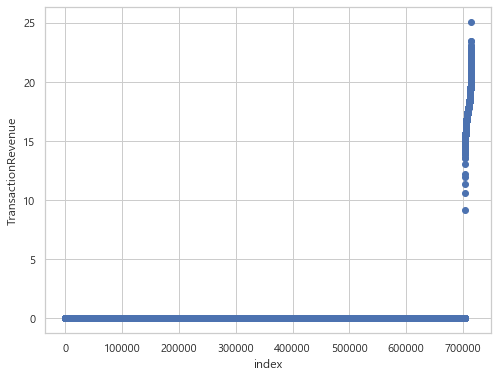

In [18]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

##### 80/20 규칙은 많은 기업에서 사실로 입증되었으며, 일부 고객들이 대부분의 수익을 창출하고 있다. 이처럼 마케팅팀은 홍보 전략에 적절한 투자를 해야 하는 과제를 안고 있다.

In [19]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("수익 0이 아닌 train 세트의 경우의 수 : ", nzi, " 비율 : ", nzi / train_df.shape[0])
print("매출 0이 아닌 고유한 고객 수 : ", nzr, " 비율 : ", nzr / gdf.shape[0])

수익 0이 아닌 train 세트의 경우의 수 :  11515  비율 :  0.0127427231470487
매출 0이 아닌 고유한 고객 수 :  9996  비율 :  0.013996726255903731


##### 따라서 수익이 발생하는 고객들의 비율은 수익이 발생하지 않는 고객들의 1.3%비율

#### 방문자 및 일반 방문자 수:

이제 train와 test에 있는 고유한 방문객들의 수와 일반 방문객의 수를 살펴보자

In [20]:
print("train set의 고유 방문자 수 : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("test set의 고유 방문자 수 : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("train 및 test set의 일반 방문자수 : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

train set의 고유 방문자 수 :  714167  out of rows :  903653
test set의 고유 방문자 수 :  617242  out of rows :  804684
train 및 test set의 일반 방문자수 :  7679


#### 일정한 값이 있는 열

train set에는 일정한 값을 가진 특징들이 꽤 많이 있다. 이 특징들의 list를 보면 일정한 값과 일부 null 값을 갖는 열을 포함하면 안된다.

In [41]:
train_df.socialEngagementType #.nunique(dropna = False)

AttributeError: 'DataFrame' object has no attribute 'socialEngagementType'

In [21]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

##### 꽤 많은데 값이 일정하기 때문에 feature 목록에서 삭제하고 모델링 프로세스에서 메모리와 시간을 절약할 수 있다.

In [22]:
# Device Information:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

C:\ProgramData\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



- 장치 브라우저 배포가 0이 아닌 수익 plot의 갯수와 갯수 모두에서 유사하게 표시됨
- device 카테고리 전면에서 데스크톱은 모바일 기기에 비해 0이 아닌 매출의 비율이 더 높은 것으로 보임
- 장치 운영 체제에서는 윈도우에서 카운트 수가 더 많지만, 수익이 0이 아닌 카운트 수는 Macintosh에서 더 많다.
- 또한 Chrome OS는 0이 아닌 수익의 비율도 더 높다.
- 모바일 OS 측면에서는 iOS가 안드로이드에 비해 0이 아닌 매출의 비율이 더 높다.

In [23]:
# Date Exploration:

import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

train 데이터 세트에 2016년 8월 1일부터 2017년 7월 31일까지 데이터가 있음
2016년 11월, 방문자 수는 증가하지만, 그 기간(평균 대비)에는 0이 아닌 매출 수가 증가하지 않는다.

In [24]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

test 세트에는 2017년 8월 2일부터 2018년 4월 30일까지 날짜가 있다. 그래서 train과 test세트 사이에는 겹치는 날짜가 없다. 따라서 이 데이터 집합에 대해 시간 기반 검증을 수행하는 것이 좋을 수 있다.

In [25]:
# Geographic Information:
# Continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

continent plot에서, 우리는 미국이 더 많은 수의 카운트와 0이 아닌 가장 높은 카운트 수를 가지고 있다는 것을 알 수 있다.
아시아와 유럽은 높은 카운트 수를 가지고 있지만, 이들 대륙의 0이 아닌 수입의 수는 상대적으로 낮다.
우리는 또한 아시아 대륙 그림에서 처음 두 점을 유추할 수 있다.
네트워크 도메인이 "(not set)"이 아닌 "unknown.unknown"인 경우, 0이 아닌 수익을 갖는 카운트 수는 더 낮은 경향이 있다.

In [26]:
# Traffic Source:
# Continent
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

In [ ]:
트래픽 소스 plot에서, 유튜브는 데이터 집합의 카운트 수가 높지만, 0이 아닌 수익 카운트의 수는 매우 적다.
구글플렉스는 트래픽 소스 플롯의 총계수 대비 0이 아닌 수익수 비율이 높다.
트래픽 소스 매체의 경우, "referral"은 "organic" 매체에 비해 0이 아닌 매출의 수가 더 많다.

#### 방문자 프로파일:

방문자의 페이지뷰 수, 방문자의 히트 수 등과 같은 방문자 프로필 변수를 보고 어떻게 보이는지 보자

In [27]:
# Page views
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')


- 이 두 변수 모두 예측성이 매우 높아 보인다.
- count plot은 자연 감소를 보여준다. 즉, 방문자 트랜잭션당 조회 수와 페이지 뷰 수를 줄이기 위해 총 카운트가 매우 높으며 방문자 트랜잭션당 조회 수가 증가하면 전체 카운트가 감소한다.
- 반면, 방문자 거래당 조회수/페이지뷰수가 증가하면, 0이 아닌 매출수가 많다는 것을 명확히 알 수 있다.

Baseline Model:

이 데이터 집합에 기본 모델을 구축해 본다. 모델을 구축하기 전에, test 데이터 set이 아닌 train 데이터 set에 있는 변수 이름을 살펴보자

In [28]:
print("test가 아닌 train 내에 있는 변수 : ", set(train_df.columns).difference(set(test_df.columns)))

test가 아닌 train 내에 있는 변수 :  {'totals.transactionRevenue', 'trafficSource.campaignCode'}


따라서 대상 변수와는 별도로 test 데이터 set에 없는 "trafficSource.campaignCode" 변수가 하나 더 있다. 그래서 우리는 모델을 만들면서 이 변수를 제거해야 한다. 또한 우리는 우리가 이전에 얻었던 지속적인 변수들을 버릴 수 있다.

또한 "sessionId"는 방문의 고유 식별자이기 때문에 제거할 수 있다.

In [31]:
len(cols_to_drop)

20

In [29]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

모델을 구축하기 위한 시간을 기준으로 개발 및 검증 분할을 생성

- 범주형 변수 처리

In [33]:
# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


- 수치형 변수 처리

In [42]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

- 2017년 5월 31일 이전을 train, 이후를 val

In [43]:
# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
val_df = train_df[train_df['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [44]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.69421
[200]	valid_0's rmse: 1.69106
[300]	valid_0's rmse: 1.69198
Early stopping, best iteration is:
[206]	valid_0's rmse: 1.69051


이제 이 새로운 토론 스레드에서 언급한 검증 데이터에 대한 평가 메트릭을 계산해 보자. 그래서 우리는 사용자의 모든 거래에 대해 합계를 내고 그 위에 로그 변환을 해야 한다. 또한 거래 수익은 0 이상일 수 있으므로 값을 0에서 0 미만으로 설정한다.

In [45]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.709731166564573


So we are getting a validation score of 1.70 using this method against the public leaderboard score of 1.44. So please be cautious while dealing with this.

Now let us prepare the submission file similar to validation set.

In [46]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [47]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.611402
1,0000049363351866189,0.001266
2,0000053049821714864,0.013097
3,0000059488412965267,0.000000
4,0000085840370633780,0.075908


Feature Importance

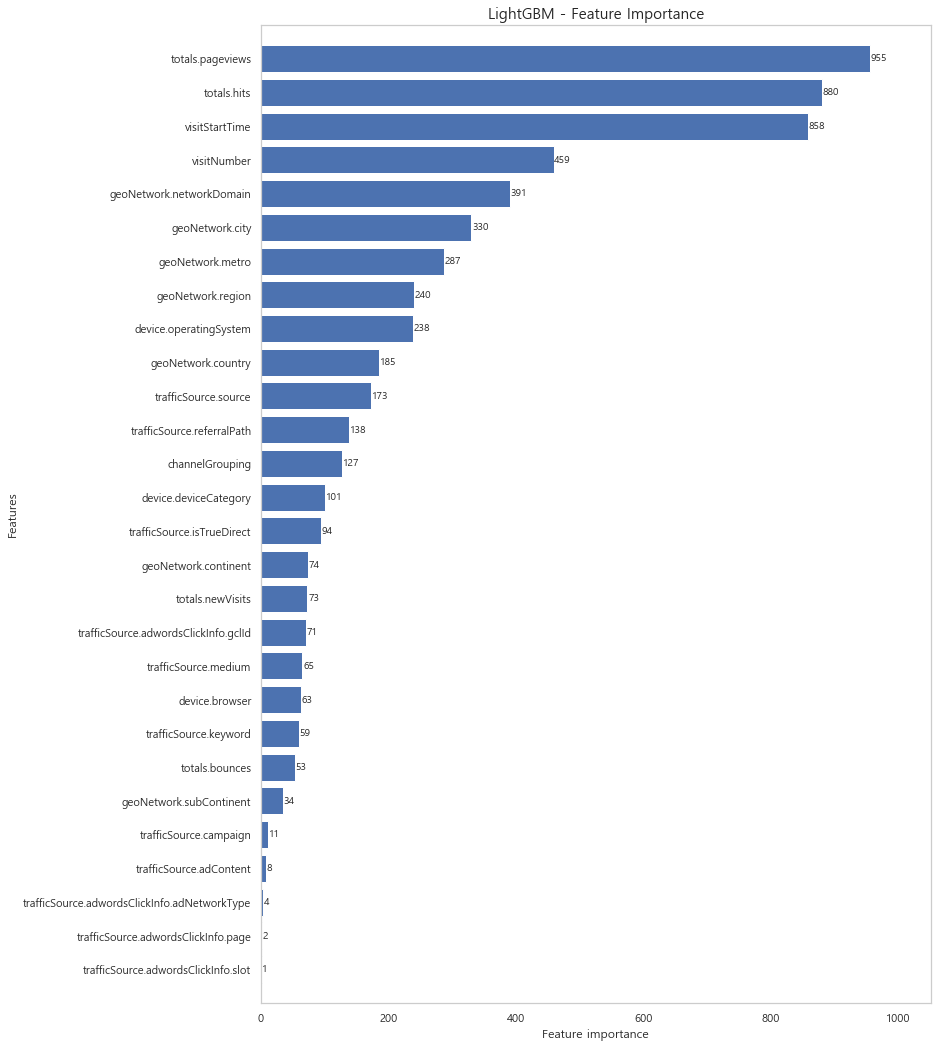

In [48]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

"totals.pageviews"가 "totals.hits"와 "visitStartTime"에 이어 가장 중요한 기능으로 나타남